In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.linalg import norm
import flopy
import flopy.utils.binaryfile as bf
%matplotlib inline
%config InlineBackend.figure_format='retina'
import rasterio
from scipy.ndimage import maximum_filter
from scipy.interpolate import griddata

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


In [2]:
import shutil
import os

def clear_directory(directory_path):
    # Check if the directory exists
    if not os.path.exists(directory_path):
        print(f"The directory {directory_path} does not exist.")
        return

    # Iterate through the directory contents
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)
        try:
            # Check if it is a file or directory and remove it accordingly
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove the file or symbolic link
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove the directory and its contents
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

In [3]:
DEM  = rasterio.open('../data/characterization_data/LiDAR/DEM_RTK.tif').read(1)
no_DEM_mask = DEM<0
DEM[DEM<0] = 2740. # Give a default value for no DEM area but wouldn't 

In [4]:
import sys

sys.path.append('../scripts/')

from Slate_Floodplain_MODFLOW import *

# Run larger MODFLOW model with no flow boundary

This no flow boundary set at least 150m away from our instrumented area, which has less impact on the final simulations for our target locations near the beaver pond. 

# Monte Carlo Simulation

In [5]:
# Default values 
hk_gravel = 8.5e-4 #m/s
hk_soil = 7.4e-5 #m/s
vka_ratio_gravel = 0.08 #m/s
vka_ratio_soil = 0.02 #m/s
k_dam = 1.6e-7 #m/s

precip = 2e-3 #m/d
ET = 2e-3 #m/d

In [6]:
mf,head,hk,vka,strt,zbot,flf,frf = modflow_BC(hk_gravel,hk_soil,vka_ratio_gravel,vka_ratio_soil,k_dam,
                                              ET,precip, 'test', './baseflow_test')

/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/flopy/utils/crs.py:121: PendingDeprecationWarning: the epsg argument will be deprecated and will be removed in version 3.6. Use crs instead.
  warnings.warn(


FloPy is using the following executable to run the model: ../../../../../../../opt/anaconda3/envs/myenv/bin/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.3.0 07/01/2022                        
                    BASED ON MODFLOW-2005 Version 1.12.0 02/03/2017                       

                    SWR1 Version 1.05.0 03/10/2022                       

 Using NAME file: test.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2025/03/19 13:35:43

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/03/19 13:36:22
 Elapsed run time: 38.951 Seconds

  Normal termination of simulation


(-0.5, 479.5, 459.5, -0.5)

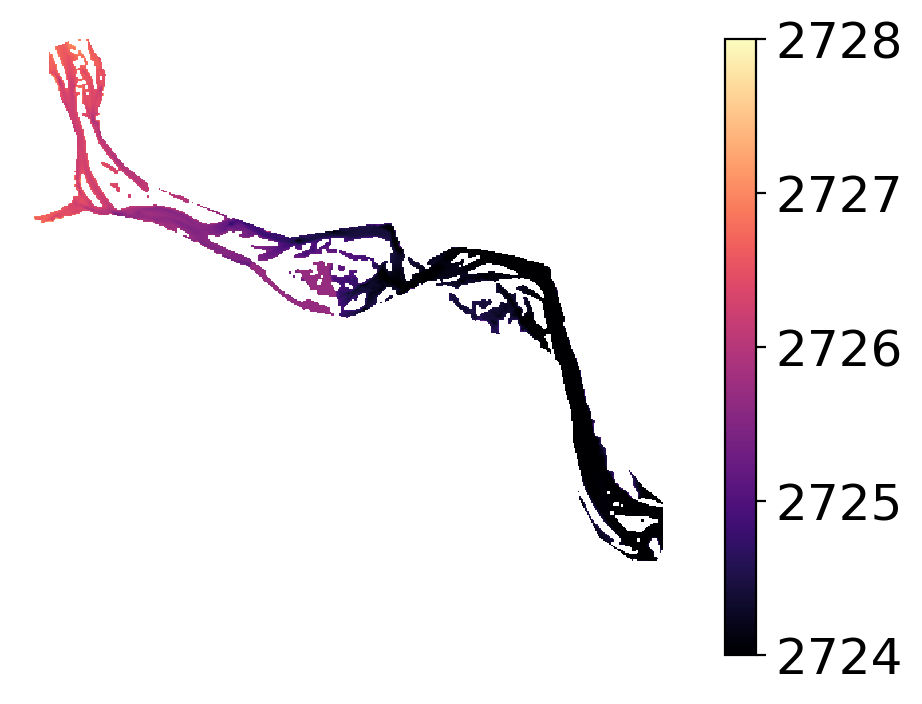

In [7]:
plt.figure(figsize=[8,4])
plt.rcParams.update({'font.size': 18})
plt.imshow(DEM,cmap = 'Greys_r',vmin = 0,vmax = 1)
head_vis = head[0,:,:]
head_vis[(river_flow_area)==0] = np.nan
plt.imshow(head_vis,vmin = 2724,vmax= 2728,cmap = 'magma')
#plt.hlines(y = 197,xmin = 100,xmax = 350,linestyle = '--',color = 'grey',linewidth = 4,label = 'Cross section')
plt.colorbar()
#plt.legend(loc = 'lower left')
plt.axis('off')

# Prior simulations, Set 1, baseflow
Let's try different combinations of hydraulic conductivies for the baseflow first. 

In [8]:
downstream = np.load('../data/characterization_data/Beaver_pond_dam/floodplain_downstream.npy')
upstream = np.load('../data/characterization_data/Beaver_pond_dam/floodplain_upstream.npy')
downstream[:,300:] = 0

In [9]:
num_MC = 300

np.random.seed(2024)
# Generate random values for hydraulic conductivity parameters
hk_gravel = np.power(10, np.random.uniform(low=-4, high=-2, size=num_MC))
hk_soil = np.power(10, np.random.uniform(low=-6, high=-4, size=num_MC))
vka_ratio_gravel = np.power(10, np.random.uniform(low=-2, high=0, size=num_MC))
vka_ratio_soil = np.power(10, np.random.uniform(low=-2, high=0, size=num_MC))
k_dam = np.power(10, np.random.uniform(low=-8, high=-6, size=num_MC))

# Create a DataFrame to store the random values
data = {
    'hk_gravel': hk_gravel,
    'hk_soil': hk_soil,
    'vka_ratio_gravel': vka_ratio_gravel,
    'vka_ratio_soil': vka_ratio_soil,
    'k_dam': k_dam
}

df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('Prior_Simulation/Prior_Parameters.csv', index=False)

In [ ]:
precip = 2e-3 #m/d
ET = 2e-3 #m/d

for i in range(300):
    hk_gravel,hk_soil,vka_ratio_gravel,vka_ratio_soil,k_dam = df.iloc[i]
    mf,head,hk,vka,strt,zbot,flf,frf = modflow_BC(hk_gravel,hk_soil,vka_ratio_gravel,vka_ratio_soil,k_dam,
                                                  ET,precip, 'sim'+str(i).zfill(3), 'Prior_Simulation/sim'+str(i).zfill(3))
    print(i)

# Simulation for other possible floodplains: varying floodplain structures, hydraulic properties, ET, precip, ponding period

In [10]:
num_MC = 500

np.random.seed(2024)

# Generate random values for hydraulic conductivity parameters
hk_gravel = np.power(10, np.random.uniform(low=-4, high=-2, size=num_MC))
hk_soil = np.power(10, np.random.uniform(low=-6, high=-4, size=num_MC))
vka_ratio_gravel = np.power(10, np.random.uniform(low=-2, high=0, size=num_MC))
vka_ratio_soil = np.power(10, np.random.uniform(low=-2, high=0, size=num_MC))
k_dam = np.power(10, np.random.uniform(low=-8, high=-6, size=num_MC))
ET = np.random.uniform(low=0, high=5e-3, size=num_MC)
precip = np.random.uniform(low=0, high=5e-3, size=num_MC)

periods = np.array(['baseflow','snowmelt','dry'])

# Perform random sampling
period = np.random.choice(periods, size=num_MC, replace=True)
structure_ratio1 = np.random.uniform(low=0, high=2, size=num_MC)
structure_ratio2 = np.random.uniform(low=0, high=2, size=num_MC)


# Create a DataFrame to store the random values
data = {
    'hk_gravel': hk_gravel,
    'hk_soil': hk_soil,
    'vka_ratio_gravel': vka_ratio_gravel,
    'vka_ratio_soil': vka_ratio_soil,
    'k_dam': k_dam, 
    'ET': ET, 
    'precip': precip, 
    'period': period, 
    'structure_ratio1': structure_ratio1, 
    'structure_ratio2': structure_ratio2, 
}

df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('Simulation_More_Variations/Parameters.csv', index=False)

In [11]:
success_label = np.zeros(num_MC)+1

In [ ]:
for i in range(num_MC):
    hk_gravel, hk_soil, vka_ratio_gravel, vka_ratio_soil, k_dam, ET, precip, period, structure_ratio1, structure_ratio2 = df.iloc[i]
    mf, head, hk, vka, strt, zbot, flf, frf = modflow_BC(hk_gravel,hk_soil,vka_ratio_gravel,vka_ratio_soil,k_dam,
                                                         ET, precip, 
                                                         'sim'+str(i).zfill(3), 'Simulation_More_Variations/sim'+str(i).zfill(3), period, 
                                                         [structure_ratio1,structure_ratio2])
    print(i)
    if np.isnan(head).any():
        success_label[i] = 0
        clear_directory('Simulation_More_Variations/sim'+str(i).zfill(3))

In [ ]:
df['success'] = success_label

In [ ]:
# Save the DataFrame to a CSV file
df.to_csv('Simulation_More_Variations/Parameters.csv', index=False)

# Visualize the result

In [91]:
hk[:,DEM<0]= np.nan

In [92]:
new_array = np.copy(hk/(3600*24))
new_array2 = np.copy(hk/(3600*24))

In [93]:
new_array[new_array<1e-7] = np.nan
new_array[new_array>1e-4] = np.nan

In [94]:
new_array2[new_array2>1e-7] = np.nan

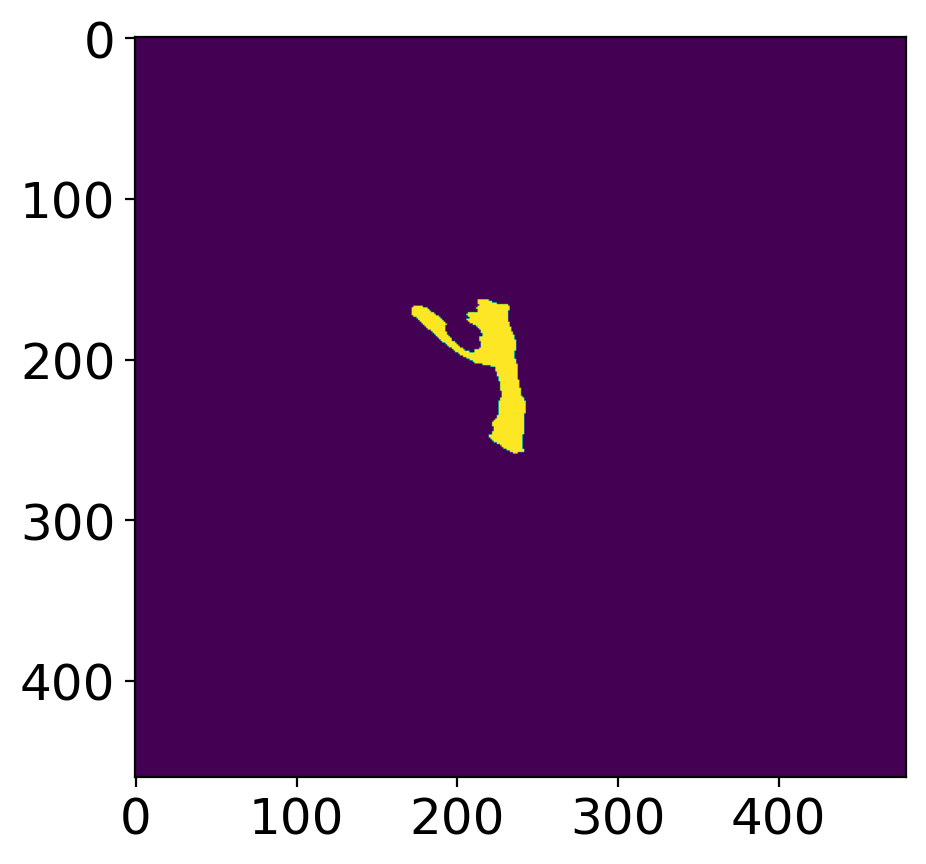

In [95]:
pond = np.load('../data/characterization_data/Beaver_pond_dam/pond_baseflow.npy')

(100.0, 350.0)

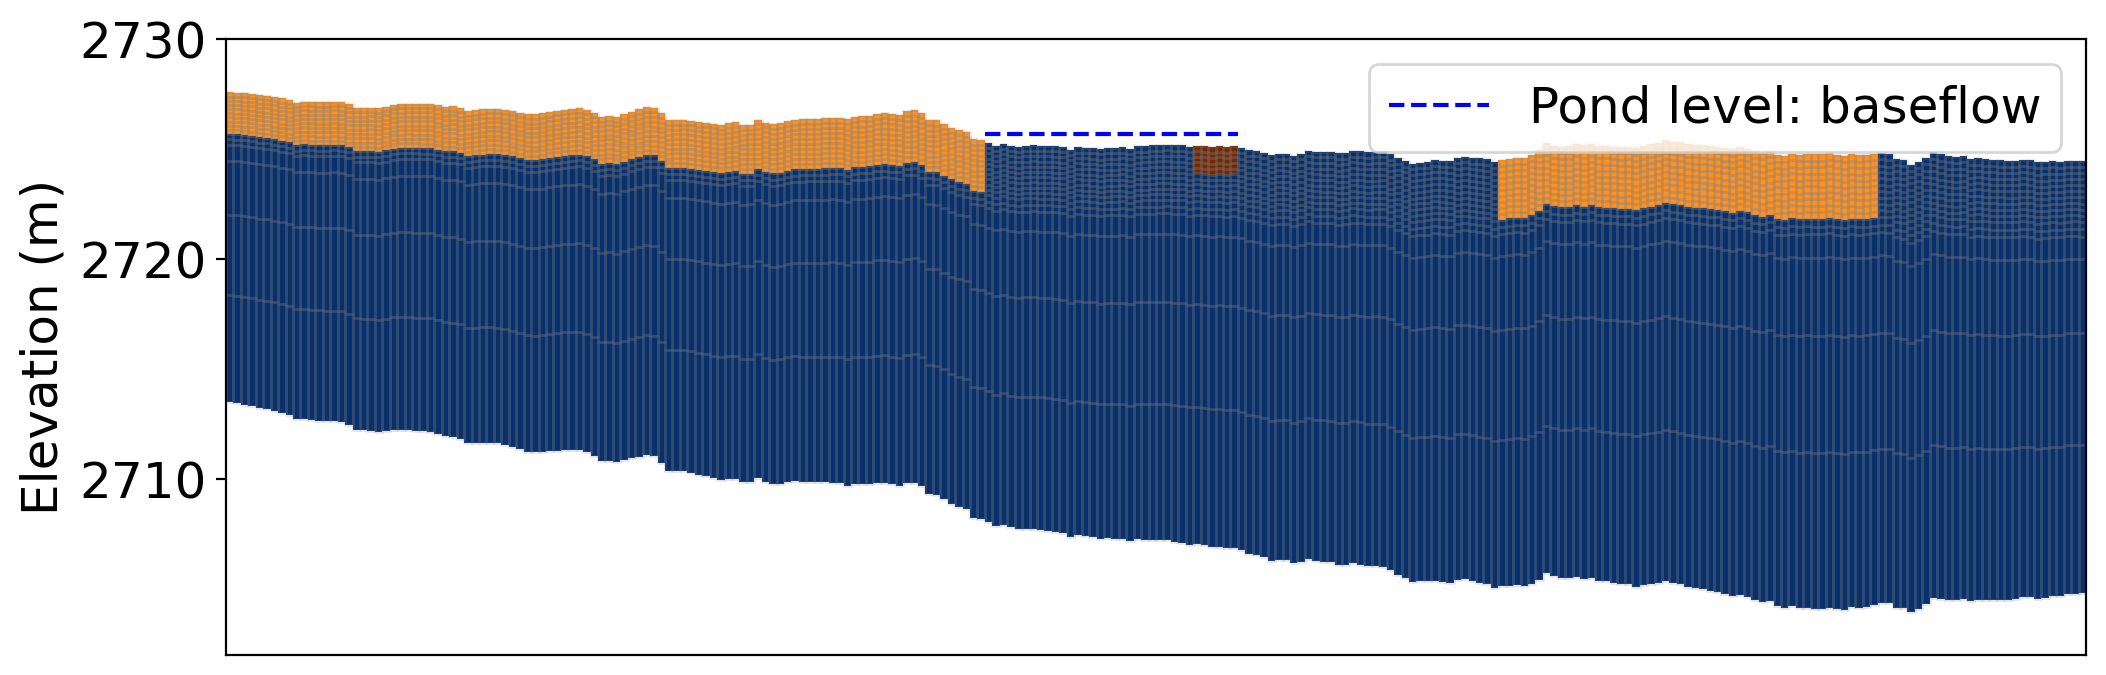

In [96]:
fig = plt.figure(figsize=(12, 4))
row_idx = 197
plt.rcParams.update({'font.size': 18})
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=mf, line={'Row': row_idx})
modelxsect.plot_array(np.log10(hk/(3600*24)),cmap = 'Blues_r',vmin = -3, vmax = -1)
modelxsect.plot_array(np.log10(new_array),cmap = 'YlOrBr_r',vmin = -7, vmax = -1)
modelxsect.plot_array(np.log10(new_array2),cmap = 'YlOrBr_r',vmin = -7, vmax = -1)

linecollection = modelxsect.plot_grid(color = 'grey',alpha = 0.2)
plt.xticks([])
plt.hlines(y = 2725.7,xmin = 202,xmax = 236,linestyles='--',color = 'blue',label = 'Pond level: baseflow')
plt.legend()
plt.locator_params(axis="y", nbins=2)
plt.ylabel('Elevation (m)')
plt.ylim(2702,2730)
plt.xlim(100,350)

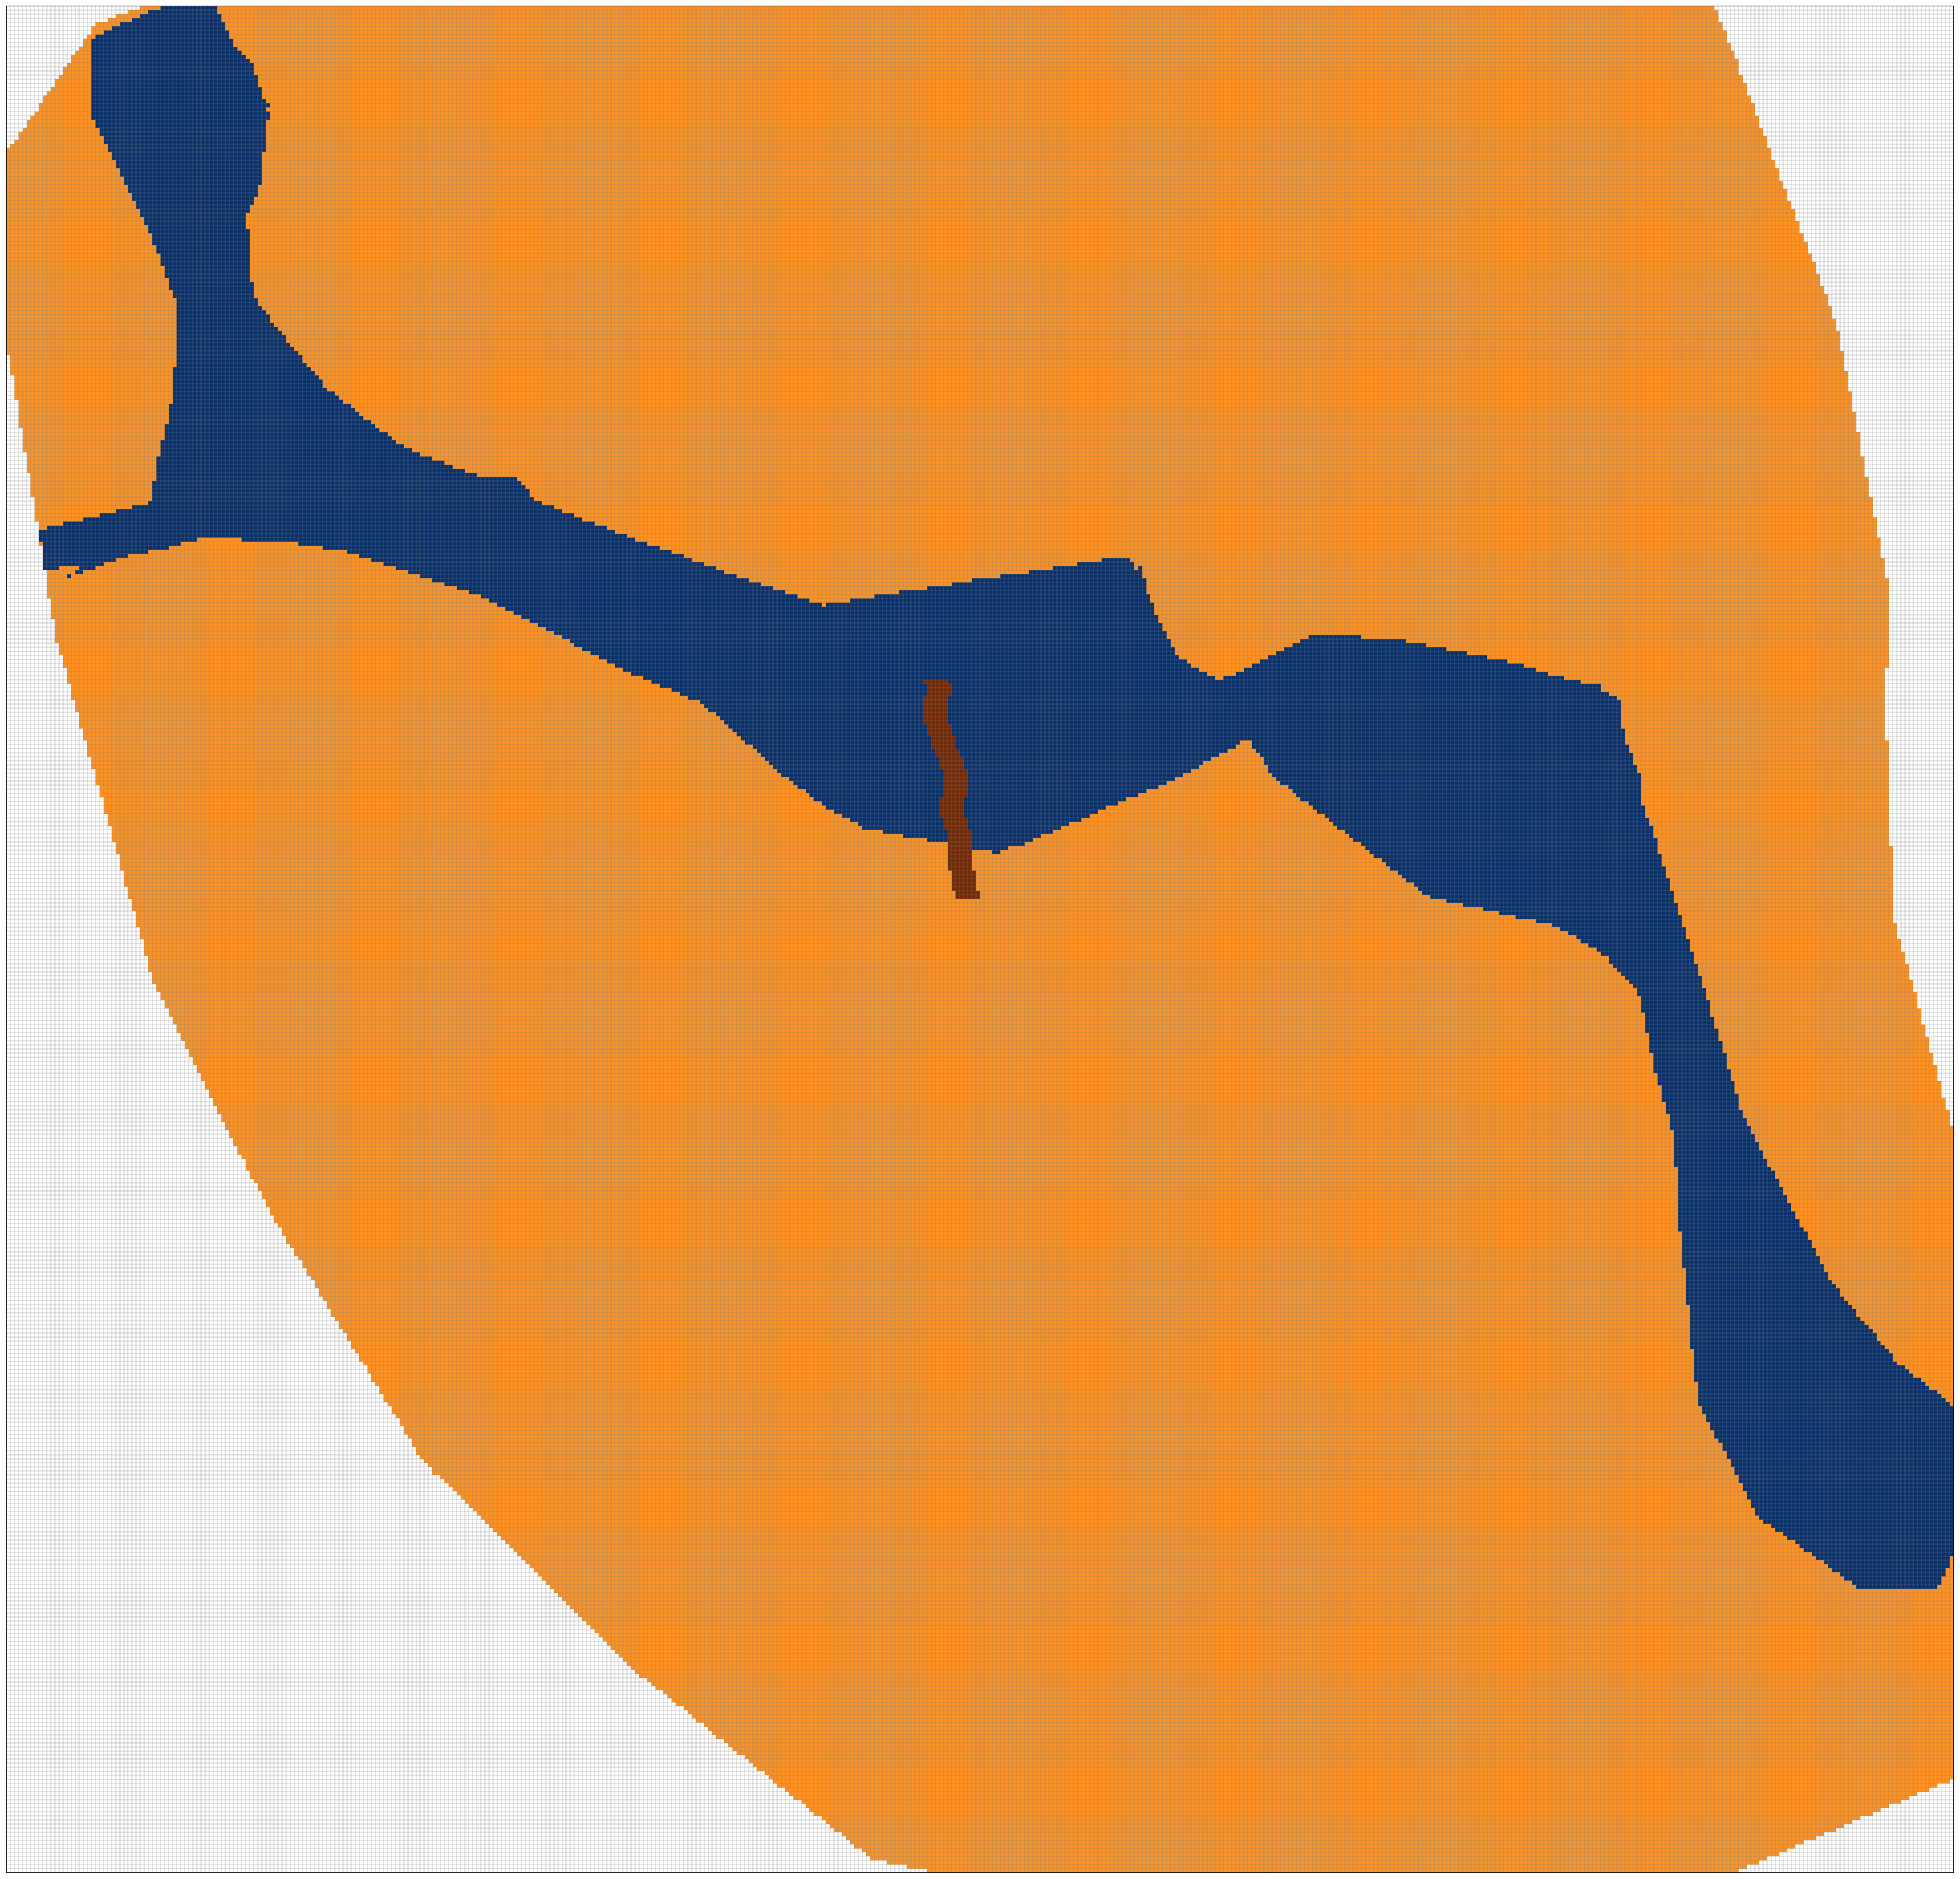

In [97]:
fig = plt.figure(figsize=(40, 40))
plt.rcParams.update({'font.size': 18})
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotMapView(model=mf)

modelxsect.plot_array(np.log10(hk/(3600*24)),cmap = 'Blues_r',vmin = -3, vmax = -1)
modelxsect.plot_array(np.log10(new_array),cmap = 'YlOrBr_r',vmin = -7, vmax = -1)
modelxsect.plot_array(np.log10(new_array2),cmap = 'YlOrBr_r',vmin = -7, vmax = -1)

linecollection = modelxsect.plot_grid(color = 'grey',alpha = 0.2)
plt.xticks([])
plt.yticks([])
plt.hlines(y = 2725.7,xmin = 202,xmax = 236,linestyles='--',color = 'blue',label = 'Pond level: baseflow')
#plt.legend()
plt.locator_params(axis="y", nbins=2)
#plt.ylabel('Elevation (m)')
#plt.ylim(2702,2730)
#plt.xlim(100,350)

In [ ]:
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1, 1, 1)
modelxsect = flopy.plot.PlotCrossSection(model=mf, line={'Row': row_idx})
modelxsect.plot_array(head,cmap = 'magma',vmin = 2724,vmax = 2726)
modelxsect.contour_array(head,cmap = 'Greys_r',levels=np.linspace(2724, 2726, 20))
#linecollection = modelxsect.plot_grid()
plt.xticks([])
plt.locator_params(axis="y", nbins=2)
plt.ylabel('Elevation (masl)')
plt.ylim(2702,2730)

#plt.imshow(DEM[(-a-275):(-a),b:(b+275)])
plt.hlines(y = 125,xmin = 0,xmax = 274,color = 'red')
plt.axis('off')
plt.show()